# Laboratory Task 7

**Lab Activity 201: Exploring Hyperparameters** <br>

Visaviern V. Mosqueda <br>
DS4A

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import os

ModuleNotFoundError: No module named 'torch'

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

## Dataset Selection

In [91]:
root = '/kaggle/input/apples-or-tomatoes-image-classification'

def make_data_dict(split):
    data_dict = {'img_paths': [], 'labels': []}
    for c_path in os.listdir(os.path.join(root, split)):
        folder_path = os.path.join(root, split, c_path)
        for img_path in os.listdir(folder_path):
            fimg_path = os.path.join(folder_path, img_path)
            data_dict['img_paths'].append(fimg_path)
            data_dict['labels'].append(c_path)
    return data_dict

train_dict = make_data_dict('train')
test_dict = make_data_dict('test')

In [92]:
df_train = pd.DataFrame(train_dict)
df_test = pd.DataFrame(test_dict)
mapping = {k: v for v, k in enumerate(sorted(os.listdir(os.path.join(root, 'train'))))}
class_names = list(mapping.keys())

print("Train Dataframe:")
display(df_train.head())

print("Test Dataframe:")
display(df_test.head())

Train Dataframe:


,img_paths,labels
0,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
1,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
2,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
3,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
4,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes


Test Dataframe:


,img_paths,labels
0,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
1,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
2,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
3,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes
4,/kaggle/input/apples-or-tomatoes-image-classif...,tomatoes


In [93]:
class CustomDataset(Dataset):
    def __init__(self, data_dict, mapping, transforms=None):
        self.data_dict = data_dict
        self.mapping = mapping
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data_dict['img_paths'])
    
    def __getitem__(self, idx):
        img = cv2.imread(self.data_dict['img_paths'][idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lbl = self.data_dict['labels'][idx]
        
        if self.transforms:
            img = self.transforms(img)
        lbl = torch.tensor(self.mapping[lbl])
        return img, lbl

In [94]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CustomDataset(train_dict, mapping, transforms=train_transforms)
test_dataset = CustomDataset(test_dict, mapping, transforms=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

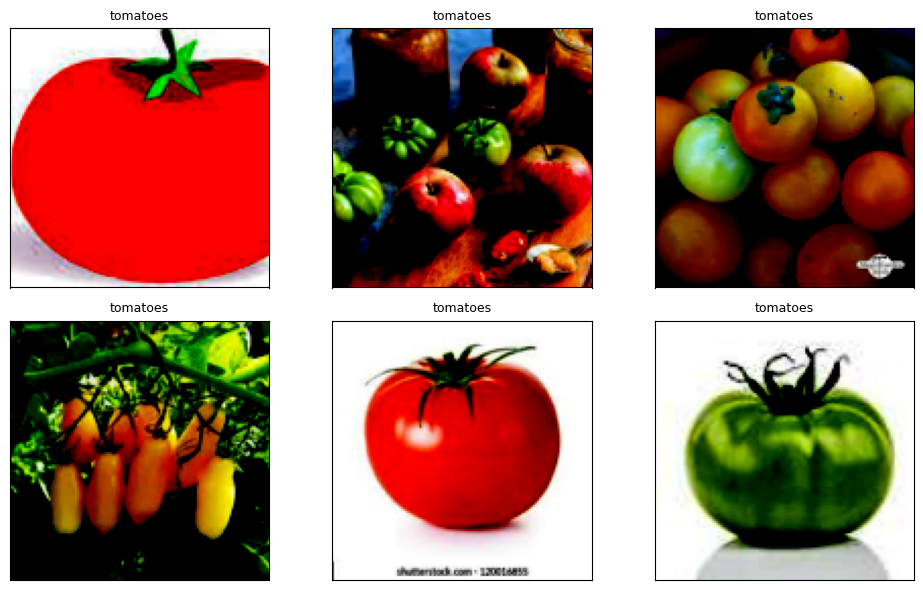

In [95]:
fig = plt.figure(figsize=(10, 6))
for i in range(6):
    img, lbl = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(class_names[lbl.item()], fontsize=9)
plt.tight_layout()
plt.show()

## Model Setup

In [96]:
# loop for experiment combinations with different activation function and optimizer
experiments = [
    {"activation": nn.ReLU, "optimizer": optim.SGD, "name": "ReLU_SGD"},
    {"activation": nn.ReLU, "optimizer": optim.Adam, "name": "ReLU_Adam"},
    {"activation": nn.LeakyReLU, "optimizer": optim.SGD, "name": "LeakyReLU_SGD"},
    {"activation": nn.LeakyReLU, "optimizer": optim.Adam, "name": "LeakyReLU_Adam"},
    {"activation": nn.ELU, "optimizer": optim.RMSprop, "name": "ELU_RMSprop"}, 
    {"activation": nn.Tanh, "optimizer": optim.Adagrad, "name": "Tanh_Adagrad"}
]

In [97]:
class FruitCNN(nn.Module):
    def __init__(self, num_classes=2, activation_fn=nn.ReLU):
        super(FruitCNN, self).__init__()
        
        # Convolutional layers (2-3 layers as per instructions)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.activation = activation_fn()
        
        # Calculate the size after convolutions and pooling
        # 128x128 -> 64x64 -> 32x32 -> 16x16
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Output layer with Softmax as per instructions
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers with activation and pooling
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        
        # Output with Softmax as required
        x = self.softmax(x)
        return x

## Training and Testing

In [98]:
def train_model(model, optimizer, criterion, train_loader, test_loader, device, epochs=15):
    model.to(device)
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Validation
        model.eval()
        correct, total = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        acc = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_val_loss)
        test_accuracies.append(acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.2f}%")
    
    return train_losses, test_losses, test_accuracies

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 15

results = {}

for exp in experiments:
    print(f"\n{'='*60}")
    print(f"Running Experiment: {exp['name']}")
    print(f"Activation: {exp['activation'].__name__}, Optimizer: {exp['optimizer'].__name__}")
    print(f"{'='*60}")

    model = FruitCNN(num_classes=2, activation_fn=exp["activation"])
    
    optimizer = exp["optimizer"](model.parameters(), lr=learning_rate)
    
    train_losses, test_losses, test_acc = train_model(
        model, optimizer, criterion, train_loader, test_loader, device, epochs=epochs
    )
    
    results[exp["name"]] = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "test_acc": test_acc,
        "final_acc": test_acc[-1]
    }

Using device: cpu

Running Experiment: ReLU_SGD
Activation: ReLU, Optimizer: SGD
Epoch [1/15] - Train Loss: 0.6961 | Val Loss: 0.6989 | Val Acc: 44.33%
Epoch [2/15] - Train Loss: 0.6950 | Val Loss: 0.6981 | Val Acc: 44.33%
Epoch [3/15] - Train Loss: 0.6950 | Val Loss: 0.6968 | Val Acc: 44.33%
Epoch [4/15] - Train Loss: 0.6942 | Val Loss: 0.6957 | Val Acc: 45.36%
Epoch [5/15] - Train Loss: 0.6935 | Val Loss: 0.6945 | Val Acc: 43.30%
Epoch [6/15] - Train Loss: 0.6928 | Val Loss: 0.6939 | Val Acc: 57.73%
Epoch [7/15] - Train Loss: 0.6923 | Val Loss: 0.6928 | Val Acc: 48.45%
Epoch [8/15] - Train Loss: 0.6914 | Val Loss: 0.6915 | Val Acc: 54.64%
Epoch [9/15] - Train Loss: 0.6912 | Val Loss: 0.6910 | Val Acc: 57.73%
Epoch [10/15] - Train Loss: 0.6901 | Val Loss: 0.6901 | Val Acc: 56.70%
Epoch [11/15] - Train Loss: 0.6893 | Val Loss: 0.6892 | Val Acc: 55.67%
Epoch [12/15] - Train Loss: 0.6899 | Val Loss: 0.6887 | Val Acc: 55.67%
Epoch [13/15] - Train Loss: 0.6891 | Val Loss: 0.6880 | Val Acc:

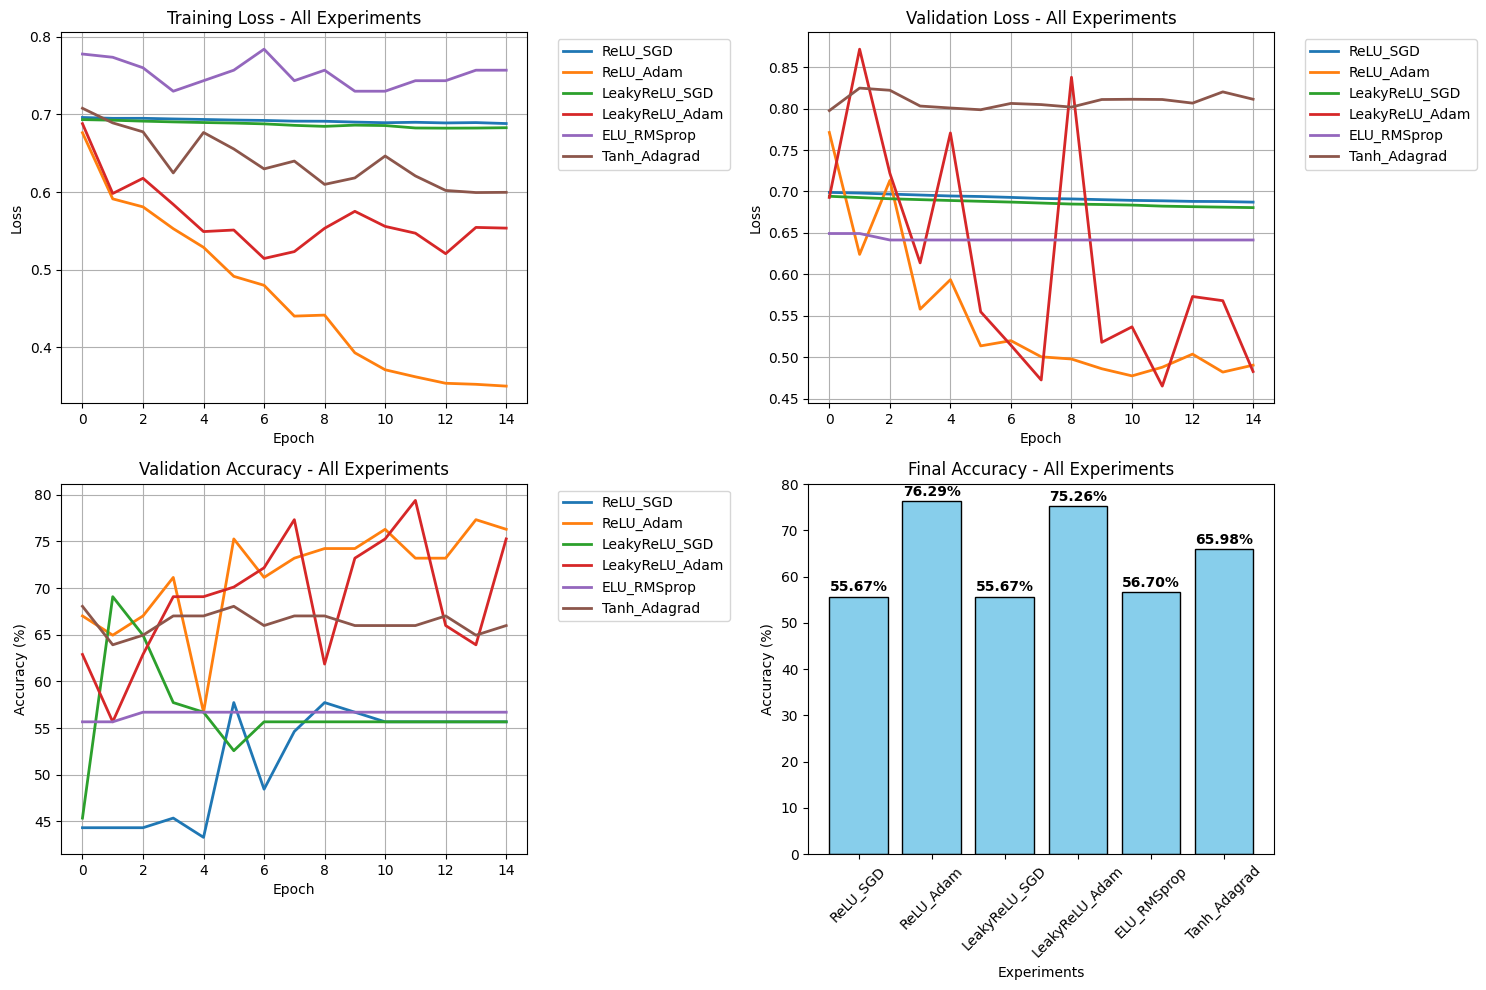

In [117]:
plt.figure(figsize=(15, 10))

# Plot 1: Training Loss
plt.subplot(2, 2, 1)
for exp_name, result in results.items():
    plt.plot(result['train_losses'], label=exp_name, linewidth=2)
plt.title('Training Loss - All Experiments')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot 2: Validation Loss
plt.subplot(2, 2, 2)
for exp_name, result in results.items():
    plt.plot(result['test_losses'], label=exp_name, linewidth=2)
plt.title('Validation Loss - All Experiments')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot 3: Validation Accuracy
plt.subplot(2, 2, 3)
for exp_name, result in results.items():
    plt.plot(result['test_acc'], label=exp_name, linewidth=2)
plt.title('Validation Accuracy - All Experiments')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot 4: Final Accuracy Comparison
plt.subplot(2, 2, 4)
exp_names = list(results.keys())
final_accuracies = [results[exp]['final_acc'] for exp in exp_names]
bars = plt.bar(exp_names, final_accuracies, color='skyblue', edgecolor='black')
plt.title('Final Accuracy - All Experiments')
plt.xlabel('Experiments')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, acc in zip(bars, final_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [118]:
print("FINAL RESULTS - ALL EXPERIMENTS")

for exp_name, result in results.items():
    print(f"{exp_name}: {result['final_acc']:.2f}%")

best_exp = max(results.items(), key=lambda x: x[1]['final_acc'])
print(f"\nBest Experiment: {best_exp[0]} with {best_exp[1]['final_acc']:.2f}% accuracy")

FINAL RESULTS - ALL EXPERIMENTS
ReLU_SGD: 55.67%
ReLU_Adam: 76.29%
LeakyReLU_SGD: 55.67%
LeakyReLU_Adam: 75.26%
ELU_RMSprop: 56.70%
Tanh_Adagrad: 65.98%

Best Experiment: ReLU_Adam with 76.29% accuracy


## Analysis and Explanation

 The ReLU_Adam combination achieved the best overall performance with **76.29%** validation accuracy, showing consistent improvement throughout training from 67.01% to its final accuracy. LeakyReLU_Adam also performed well, reaching **75.26%** accuracy despite some instability in later epochs. In contrast, ReLU_SGD and LeakyReLU_SGD struggled significantly, both having only **55.67%** accuracy, while ELU_RMSprop showed complete stagnation at **56.70%** after just a few epochs, and Tanh_Adagrad managed only **65.98%** with inconsistent performance.

The dramatic difference between Adam and SGD optimizers highlights how optimization strategy fundamentally impacts learning. Adam's adaptive learning rates enabled rapid convergence and stable improvement, as seen in both ReLU_Adam and LeakyReLU_Adam, where training losses decreased steadily from ~0.68 to ~0.35 and ~0.55 respectively. Meanwhile, SGD's fixed learning rate caused extremely slow progress, with losses decreasing only marginally from ~0.69 to ~0.68 over 15 epochs. The ELU_RMSprop combination suffered from complete learning paralysis, likely due to RMSprop's sensitivity to hyperparameters combined with ELU's smooth characteristics, resulting in no improvement after epoch 4. Tanh_Adagrad showed the negative effects of combining a saturating activation function with an optimizer that aggressively decays learning rates, preventing effective convergence.

Regarding activation functions, ReLU and LeakyReLU demonstrated their superiority by enabling effective gradient flow when paired with appropriate optimizers. LeakyReLU showed slightly more stability than ReLU in handling negative inputs, though both performed excellently with Adam. The ELU activation failed to provide any advantage in this architecture, possibly due to its exponential complexity not complementing RMSprop's adaptation mechanism. Tanh's saturation problems were evident in its inability to achieve high accuracy despite reasonable initial performance.

The ReLU_Adam combination achieved the best trade-off between accuracy and generalization, maintaining a reasonable gap between training and validation losses while reaching the highest final accuracy. Its training curve showed steady improvement without dramatic overfitting, unlike LeakyReLU_Adam which exhibited more volatility in later epochs. The SGD-based combinations, while showing less overfitting, failed to learn meaningful patterns altogether. For practical applications, ReLU_Adam would be the recommended choice given its strong, stable performance, though LeakyReLU_Adam might warrant consideration with additional regularization to address its instability issues. These results strongly reinforce that modern adaptive optimizers like Adam are essential for effective deep learning, as they can compensate for various activation function limitations while enabling efficient convergence.